### Summary of Techniques Used in 03_train_mnist.ipynb

#### Data Handling & Augmentation
- MNIST dataset with MNISTAlbumentations wrapper
- Enhanced augmentation pipeline:
  - ShiftScaleRotate transformation (p=0.25)
  - Shift limit: ±6.25%
  - Scale limit: ±5%
  - Rotation limit: ±7 degrees
- Standard normalization (mean=0.1307, std=0.3081)

#### Model Architecture (Model3)
- Similar to Model2 but with added dropout layers
- Features:
  - ReLU activation
  - BatchNormalization
  - **Dropout (p=0.04) after each conv block**
  - MaxPooling
  - Global Average Pooling
- Total params: 7,236 (same as Model2)

#### Training Configuration
- Batch size: 512
- Optimizer: SGD with momentum
- OneCycleLR scheduler
- max_lr: 0.15
- Initial div factor: 25
- Final div factor: 175
- Warmup percentage: 30%
- Dropout rate: 0.04
- Number of epochs: 15

#### **Target, Result & Analysis**
- Target: 99.5%+ test accuracy
- Result: Achieved 99.53% best test accuracy

####Analysis:

1. Target Justification:
- Added dropout regularization
- Enhanced data augmentation
- Proven architecture from Model2
- Literature shows >99.5% possible with proper regularization
- Combined benefits of augmentation and dropout

2. Architecture Analysis:
- Same powerful base as Model2
- Strategic dropout placement after each block
- Balanced regularization approach:
  - Spatial (MaxPool)
  - Feature (Dropout)
  - Statistical (BatchNorm)
- Maintains model capacity while improving generalization

3. Results Analysis:
- Training accuracy: 99.52% (minimal overfitting)
- Test accuracy peaked at 99.53% (met target)
- More stable learning curve
- Better generalization than both Model1 and Model2
- Consistent performance in final epochs

4. Improvements over Previous Models:
- Model1: +0.51% (99.02% → 99.53%)
- Model2: +0.14% (99.39% → 99.53%)
- Better regularization strategy
- More robust to variations (augmentation)
- Better generalization with similar training time

5. Key Success Factors:
- Combined regularization techniques
- Strategic data augmentation
- Optimal dropout rate (0.04)
- Well-tuned OneCycleLR parameters
- Balanced architecture design

6. Potential Further Improvements:
- Try different augmentation strategies
- Experiment with other dropout patterns
- Test different learning rate ranges
- Consider adding skip connections
- Investigate other regularization techniques

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import numpy as np
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2
from model import Model3 as Net
from utils import visualize_augmentations
from train import train, test
import cv2

#### Device Configuration

In [2]:

use_cuda = torch.cuda.is_available()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if use_cuda else "cpu")


#### Custom Dataset

In [3]:
class MNISTAlbumentations(datasets.MNIST):
    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root, train=train, download=download, transform=None)
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        img = np.array(img)
        img = np.expand_dims(img, axis=-1)  # Add channel dimension for Albumentations
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed["image"]
            
        return img, label


###################
# Data Augmentation
###################

# Training augmentation pipeline
train_transforms = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.0625,
        scale_limit=0.05,
        rotate_limit=7,
        p=0.25,
        border_mode=cv2.BORDER_CONSTANT,
        value=0
    ),
    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

# Test transforms (only normalization)
test_transforms = A.Compose([
    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])


In [4]:
# Initial setup
torch.manual_seed(14596)

# Training parameters
batch_size = 512
kwargs = {'num_workers': 0, 'pin_memory': True} if device.type in ["cuda", "mps"] else {}

# Initialize model and print summary
model = Net(0.01).to(device)
print(summary(model, input_size=(1, 1, 28, 28), device=device))


Layer (type:depth-idx)                   Output Shape              Param #
Model3                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 12, 26, 26]           --
│    └─Conv2d: 2-1                       [1, 12, 26, 26]           108
│    └─ReLU: 2-2                         [1, 12, 26, 26]           --
│    └─BatchNorm2d: 2-3                  [1, 12, 26, 26]           24
│    └─Dropout: 2-4                      [1, 12, 26, 26]           --
├─Sequential: 1-2                        [1, 16, 24, 24]           --
│    └─Conv2d: 2-5                       [1, 16, 24, 24]           1,728
│    └─ReLU: 2-6                         [1, 16, 24, 24]           --
│    └─BatchNorm2d: 2-7                  [1, 16, 24, 24]           32
│    └─Dropout: 2-8                      [1, 16, 24, 24]           --
├─Sequential: 1-3                        [1, 10, 24, 24]           --
│    └─Conv2d: 2-9                       [1, 10, 24, 24]           160
├─MaxPool2

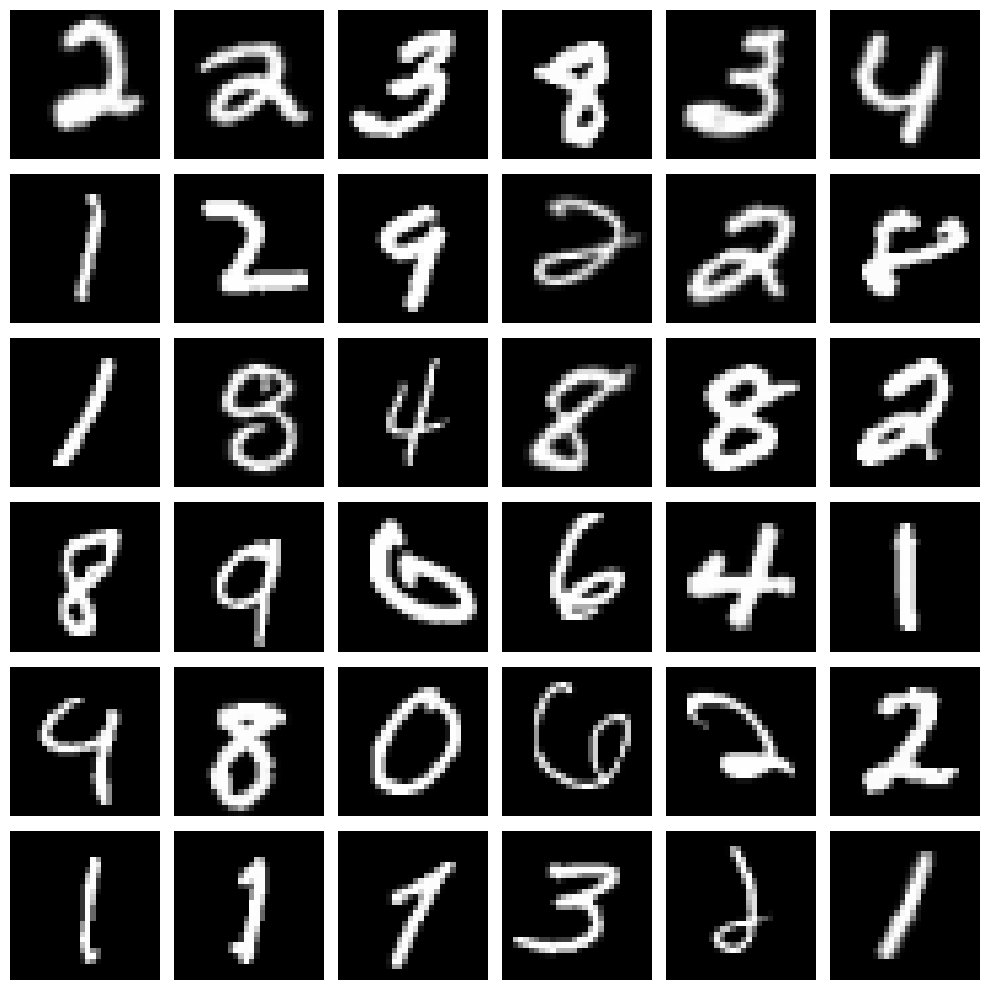

In [5]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=True, download=True, transform=train_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=False, transform=test_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)

visualize_augmentations(train_loader.dataset)

In [6]:
max_lr = 0.15
initial_div = 25
final_div = 175
warmup_pct = 0.3
momentum = 0.95
weight_decay = 0.0005
drop_out = 0.04

num_epochs = 15
# Initialize model and optimizer
model = Net(drop_out).to(device)
optimizer = optim.SGD(
    model.parameters(),
    lr=max_lr/initial_div,
    momentum=momentum,
    weight_decay=weight_decay
)

# Setup OneCycle scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=warmup_pct,
    div_factor=initial_div,
    final_div_factor=final_div
)

# Training Loop
best_accuracy = 0
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    train(model, device, train_loader, optimizer, epoch, scheduler)
    accuracy = test(model, device, test_loader)
    best_accuracy = max(best_accuracy, accuracy)

print(f"\nBest accuracy achieved: {best_accuracy:.2f}%")


Epoch 1/15
Learning rate: 0.006000


Training set: loss=0.31766 accuracy=62.44% batch_id=117: 100%|██████████| 118/118 [00:08<00:00, 14.27it/s]


Test set: Average loss: 0.21595, Accuracy: 9469/10000 (94.69%)

Epoch 2/15
Learning rate: 0.022906


Training set: loss=0.07548 accuracy=96.56% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 35.92it/s]


Test set: Average loss: 0.06096, Accuracy: 9839/10000 (98.39%)

Epoch 3/15
Learning rate: 0.065684


Training set: loss=0.10818 accuracy=98.03% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 36.27it/s]


Test set: Average loss: 0.05133, Accuracy: 9850/10000 (98.50%)

Epoch 4/15
Learning rate: 0.114246


Training set: loss=0.05920 accuracy=98.39% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 35.37it/s]


Test set: Average loss: 0.04577, Accuracy: 9862/10000 (98.62%)

Epoch 5/15
Learning rate: 0.145787


Training set: loss=0.08802 accuracy=98.60% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 36.52it/s]


Test set: Average loss: 0.04115, Accuracy: 9875/10000 (98.75%)

Epoch 6/15
Learning rate: 0.149134


Training set: loss=0.02498 accuracy=98.65% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 35.75it/s]


Test set: Average loss: 0.03185, Accuracy: 9904/10000 (99.04%)

Epoch 7/15
Learning rate: 0.142492


Training set: loss=0.02672 accuracy=98.85% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 35.51it/s]


Test set: Average loss: 0.03545, Accuracy: 9894/10000 (98.94%)

Epoch 8/15
Learning rate: 0.129854


Training set: loss=0.02423 accuracy=98.91% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 36.58it/s]


Test set: Average loss: 0.02956, Accuracy: 9914/10000 (99.14%)

Epoch 9/15
Learning rate: 0.112344


Training set: loss=0.02811 accuracy=98.99% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 36.17it/s]


Test set: Average loss: 0.02603, Accuracy: 9924/10000 (99.24%)

Epoch 10/15
Learning rate: 0.091517


Training set: loss=0.12810 accuracy=99.03% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 36.58it/s]


Test set: Average loss: 0.02611, Accuracy: 9921/10000 (99.21%)

Epoch 11/15
Learning rate: 0.069224


Training set: loss=0.00992 accuracy=99.15% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 35.87it/s]


Test set: Average loss: 0.02278, Accuracy: 9940/10000 (99.40%)

Epoch 12/15
Learning rate: 0.047446


Training set: loss=0.02265 accuracy=99.24% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 36.02it/s]


Test set: Average loss: 0.02180, Accuracy: 9938/10000 (99.38%)

Epoch 13/15
Learning rate: 0.028118


Training set: loss=0.01845 accuracy=99.30% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 35.99it/s]


Test set: Average loss: 0.02047, Accuracy: 9938/10000 (99.38%)

Epoch 14/15
Learning rate: 0.012956


Training set: loss=0.00418 accuracy=99.40% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 35.04it/s]


Test set: Average loss: 0.01871, Accuracy: 9953/10000 (99.53%)

Epoch 15/15
Learning rate: 0.003310


Training set: loss=0.03209 accuracy=99.52% batch_id=117: 100%|██████████| 118/118 [00:03<00:00, 35.93it/s]


Test set: Average loss: 0.01864, Accuracy: 9950/10000 (99.50%)


Best accuracy achieved: 99.53%
